**1. Consider the weather.csv data file. This file contains weather data recorded in one minute interval from weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured. Each row in weather.csv contains weather data captured for a one-minute interval. In Python, answer the following:**

**(a) (5 points) Using the pandas library, read the csv data file from your S3 bucket and create a data-frame called weather. Select data up to October 31, 2011. After that, remove any observation with missing values.**

In [9]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'craig-shaffer-data-445-bucket'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'weather.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading the datafile
weather = pd.read_csv(file_content_stream)
weather.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


In [10]:
#selecting only the data up to 10-31-2011 (all data with 'hpwren_timestamp' less than 11-01-2011)
weather_filtered = weather.loc[(weather['hpwren_timestamp'] < '2011-11-01')]
weather_filtered

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74480,74480,2011-10-31 23:55:49,916.6,67.10,229.0,0.6,233.0,0.8,226.0,0.5,0.0,0.0,17.6
74481,74481,2011-10-31 23:56:49,916.6,66.92,232.0,0.7,253.0,0.9,224.0,0.5,0.0,0.0,17.6
74482,74482,2011-10-31 23:57:49,916.6,66.92,252.0,0.7,261.0,0.8,242.0,0.6,0.0,0.0,18.4
74483,74483,2011-10-31 23:58:49,916.5,66.74,253.0,0.8,269.0,1.1,246.0,0.5,0.0,0.0,18.5


In [11]:
#dropping observations w/ missing values
weather_filtered=weather_filtered.dropna()

**(b) (8 points) After consulting with a meteorologist, he recommends to use the following variables for clustering purposes: air pressure, air temp, avg wind direction, avg wind speed, max wind direction, max wind speed, and relative humidity. Transform all the variables of interest to 0-1 scale.**

In [12]:
#dropping unnecessary columns
weather_filtered=weather_filtered.drop(columns= ['rowID', 'hpwren_timestamp', 'min_wind_direction', 'min_wind_speed', 'rain_accumulation', 'rain_duration'], axis= 1)
weather_filtered.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
1,912.3,63.86,161.0,0.8,215.0,1.5,39.9
2,912.3,64.22,77.0,0.7,143.0,1.2,43.0
3,912.3,64.40,89.0,1.2,112.0,1.6,49.5
4,912.3,64.40,185.0,0.4,260.0,1.0,58.8
5,912.3,63.50,76.0,2.5,92.0,3.0,62.6


In [13]:
#transforming the data to a 0-1 scale
scaler=MinMaxScaler()
weather_filtered[['air_pressure_01','air_temp_01','avg_wind_direction_01','avg_wind_speed_01','max_wind_direction_01','max_wind_speed_01','relative_humidity_01']] = scaler.fit_transform(weather_filtered)
weather_filtered.head(10)

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01
1,912.3,63.86,161.0,0.8,215.0,1.5,39.9,0.16,0.403922,0.448468,0.034188,0.598886,0.054264,0.400000
2,912.3,64.22,77.0,0.7,143.0,1.2,43.0,0.16,0.411765,0.214485,0.029915,0.398329,0.042636,0.435429
3,912.3,64.40,89.0,1.2,112.0,1.6,49.5,0.16,0.415686,0.247911,0.051282,0.311978,0.058140,0.509714
4,912.3,64.40,185.0,0.4,260.0,1.0,58.8,0.16,0.415686,0.515320,0.017094,0.724234,0.034884,0.616000
5,912.3,63.50,76.0,2.5,92.0,3.0,62.6,0.16,0.396078,0.211699,0.106838,0.256267,0.112403,0.659429
6,912.3,62.78,79.0,2.4,89.0,2.7,65.6,0.16,0.380392,0.220056,0.102564,0.247911,0.100775,0.693714
7,912.3,62.42,86.0,2.0,92.0,2.4,65.2,0.16,0.372549,0.239554,0.085470,0.256267,0.089147,0.689143
8,912.3,62.24,105.0,1.4,125.0,1.9,65.8,0.16,0.368627,0.292479,0.059829,0.348189,0.069767,0.696000
9,912.3,62.24,93.0,0.4,126.0,0.7,58.6,0.16,0.368627,0.259053,0.017094,0.350975,0.023256,0.613714
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5,0.16,0.368627,0.401114,0.051282,0.465181,0.065891,0.384000


**(c) (8 points) Using the silhouette score, estimate the number of clusters for this dataset. Consider 2 to 20 clusters. Make sure to use n init = 20 in the KMeans function from the sklearn.cluster library.**

In [14]:
#define a list to hold silhouette scores
silhouette = list()
for i in range (2,21):
    
    #clustering the data into i clusters
    kmeans_md = KMeans(n_clusters = i, n_init=20).fit(weather_filtered[['air_pressure_01','air_temp_01','avg_wind_direction_01','avg_wind_speed_01','max_wind_direction_01','max_wind_speed_01','relative_humidity_01']])
    kmeans_md_labels = kmeans_md.labels_
    
    #computing silhouette score
    score = silhouette_score(weather_filtered[['air_pressure_01','air_temp_01','avg_wind_direction_01','avg_wind_speed_01','max_wind_direction_01','max_wind_speed_01','relative_humidity_01']],kmeans_md_labels)
    silhouette.append(score)

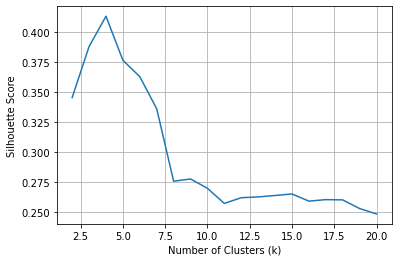

In [15]:
#visualizing results
plt.plot(range(2,21),silhouette)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show();

3 clusters has the highest silhouette score.

**(d) (6 points) Using the KMeans function from the sklearn.cluster library, cluster the customers into the number of clusters estimated from part (c).**

In [17]:
#clustering the data
four_clusters = KMeans(n_clusters=4,n_init=20).fit(weather_filtered[['air_pressure_01','air_temp_01','avg_wind_direction_01','avg_wind_speed_01','max_wind_direction_01','max_wind_speed_01','relative_humidity_01']])

#appending cluster labels
weather_filtered['cluster']= four_clusters.labels_
weather_filtered.head(10)

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
1,912.3,63.86,161.0,0.8,215.0,1.5,39.9,0.16,0.403922,0.448468,0.034188,0.598886,0.054264,0.400000,2
2,912.3,64.22,77.0,0.7,143.0,1.2,43.0,0.16,0.411765,0.214485,0.029915,0.398329,0.042636,0.435429,1
3,912.3,64.40,89.0,1.2,112.0,1.6,49.5,0.16,0.415686,0.247911,0.051282,0.311978,0.058140,0.509714,1
4,912.3,64.40,185.0,0.4,260.0,1.0,58.8,0.16,0.415686,0.515320,0.017094,0.724234,0.034884,0.616000,0
5,912.3,63.50,76.0,2.5,92.0,3.0,62.6,0.16,0.396078,0.211699,0.106838,0.256267,0.112403,0.659429,1
6,912.3,62.78,79.0,2.4,89.0,2.7,65.6,0.16,0.380392,0.220056,0.102564,0.247911,0.100775,0.693714,0
7,912.3,62.42,86.0,2.0,92.0,2.4,65.2,0.16,0.372549,0.239554,0.085470,0.256267,0.089147,0.689143,0
8,912.3,62.24,105.0,1.4,125.0,1.9,65.8,0.16,0.368627,0.292479,0.059829,0.348189,0.069767,0.696000,0
9,912.3,62.24,93.0,0.4,126.0,0.7,58.6,0.16,0.368627,0.259053,0.017094,0.350975,0.023256,0.613714,0
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5,0.16,0.368627,0.401114,0.051282,0.465181,0.065891,0.384000,2


**(e) (8 points) Describe each of the clusters. Does the clustering results make sense? if not, suggest how would improve this analysis.**

In [18]:
#Cluster 0
cluster_0 = weather_filtered[weather_filtered['cluster']==0]
cluster_0.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.000000,16483.0
mean,915.715125,54.492902,192.786750,2.552612,203.246436,3.155366,82.091573,0.501512,0.199845,0.537010,0.109086,0.566146,0.118425,0.882189,0.0
std,1.769726,5.358686,68.791657,1.899512,70.659075,2.242581,11.125948,0.176973,0.116747,0.191620,0.081176,0.196822,0.086922,0.127154,0.0
min,910.700000,45.320000,0.000000,0.100000,0.000000,0.100000,47.500000,0.000000,0.000000,0.000000,0.004274,0.000000,0.000000,0.486857,0.0
25%,914.700000,50.720000,172.000000,1.100000,184.000000,1.500000,71.900000,0.400000,0.117647,0.479109,0.047009,0.512535,0.054264,0.765714,0.0
50%,915.700000,53.060000,196.000000,2.100000,208.000000,2.600000,89.000000,0.500000,0.168627,0.545961,0.089744,0.579387,0.096899,0.961143,0.0
75%,916.900000,58.100000,226.000000,3.500000,239.000000,4.300000,91.500000,0.620000,0.278431,0.629526,0.149573,0.665738,0.162791,0.989714,0.0
max,920.000000,68.900000,359.000000,23.400000,359.000000,25.900000,92.400000,0.930000,0.513725,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [19]:
#Cluster 1
cluster_1 = weather_filtered[weather_filtered['cluster']==1]
cluster_1.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.000000,28506.0
mean,917.000435,70.893317,42.647618,2.158640,58.296639,2.616414,30.416309,0.630043,0.557153,0.118796,0.092250,0.162386,0.097535,0.291615,1.0
std,1.532916,6.824547,27.994906,1.324846,30.502953,1.548895,13.257963,0.153292,0.148683,0.077980,0.056617,0.084966,0.060035,0.151520,0.0
min,911.300000,46.040000,0.000000,0.100000,0.000000,0.100000,4.900000,0.060000,0.015686,0.000000,0.004274,0.000000,0.000000,0.000000,1.0
25%,915.700000,66.020000,20.000000,1.200000,37.000000,1.500000,21.500000,0.500000,0.450980,0.055710,0.051282,0.103064,0.054264,0.189714,1.0
50%,917.200000,71.240000,40.000000,1.800000,53.000000,2.200000,28.200000,0.650000,0.564706,0.111421,0.076923,0.147632,0.081395,0.266286,1.0
75%,918.200000,75.560000,58.000000,2.800000,72.000000,3.300000,35.900000,0.750000,0.658824,0.161560,0.119658,0.200557,0.124031,0.354286,1.0
max,920.700000,90.680000,132.000000,8.900000,248.000000,11.000000,79.700000,1.000000,0.988235,0.367688,0.380342,0.690808,0.422481,0.854857,1.0


In [20]:
#Cluster 2
cluster_2 = weather_filtered[weather_filtered['cluster']==2]
cluster_2.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.000000,26052.0
mean,917.002127,72.803994,213.749040,2.169956,231.648050,2.692077,34.308771,0.630213,0.598780,0.595401,0.092733,0.645259,0.100468,0.336100,2.0
std,1.561935,5.545925,53.464946,1.306422,54.833073,1.467511,13.172200,0.156194,0.120826,0.148927,0.055830,0.152738,0.056880,0.150539,0.0
min,911.100000,52.520000,66.000000,0.000000,141.000000,0.100000,4.900000,0.040000,0.156863,0.183844,0.000000,0.392758,0.000000,0.000000,2.0
25%,915.900000,68.720000,178.000000,1.100000,190.000000,1.500000,24.500000,0.520000,0.509804,0.495822,0.047009,0.529248,0.054264,0.224000,2.0
50%,917.100000,72.500000,202.000000,2.000000,216.000000,2.500000,32.500000,0.640000,0.592157,0.562674,0.085470,0.601671,0.093023,0.315429,2.0
75%,918.100000,77.000000,227.000000,3.000000,253.000000,3.600000,43.800000,0.740000,0.690196,0.632312,0.128205,0.704735,0.135659,0.444571,2.0
max,920.700000,91.220000,357.000000,8.600000,359.000000,10.100000,66.200000,1.000000,1.000000,0.994429,0.367521,1.000000,0.387597,0.700571,2.0


In [21]:
#Cluster 3
cluster_3 = weather_filtered[weather_filtered['cluster']==3]
cluster_3.describe()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,air_pressure_01,air_temp_01,avg_wind_direction_01,avg_wind_speed_01,max_wind_direction_01,max_wind_speed_01,relative_humidity_01,cluster
count,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.000000,3428.0
mean,916.821091,70.618139,341.355601,1.519632,20.840432,2.134656,33.058285,0.612109,0.551158,0.950851,0.064942,0.058051,0.078863,0.321809,3.0
std,1.421600,7.339185,20.137444,1.005371,22.336000,1.273741,14.215578,0.142160,0.159895,0.056093,0.042965,0.062217,0.049370,0.162464,0.0
min,911.600000,46.220000,209.000000,0.000000,0.000000,0.100000,8.700000,0.090000,0.019608,0.582173,0.000000,0.000000,0.000000,0.043429,3.0
25%,915.900000,66.380000,335.000000,0.700000,5.000000,1.200000,24.300000,0.520000,0.458824,0.933148,0.029915,0.013928,0.042636,0.221714,3.0
50%,916.800000,71.420000,348.000000,1.300000,13.000000,1.900000,29.400000,0.610000,0.568627,0.969359,0.055556,0.036212,0.069767,0.280000,3.0
75%,917.900000,76.280000,355.000000,2.100000,28.000000,2.800000,39.000000,0.720000,0.674510,0.988858,0.089744,0.077994,0.104651,0.389714,3.0
max,920.700000,90.500000,359.000000,7.000000,141.000000,8.700000,90.100000,1.000000,0.984314,1.000000,0.299145,0.392758,0.333333,0.973714,3.0


cluster 0 is 0.501512 | 0.199845 | 0.537010 | 0.109086 | 0.566146 | 0.118425 | 0.882189 
- lowest air pressure, lowest air temp, mid avg wind direction, highest avg wind speed, high max wind direction, highest max wind speed, highest relative humidity

cluster 1 is 0.630043 | 0.557153 | 0.118796 | 0.092250 | 0.162386 | 0.097535 | 0.291615
- high air pressure, high air temp, lowest avg wind direction, high avg wind speed, low max wind direction, mid max wind speed, lowest relative humidity

cluster 2 is 0.630213 | 0.598780 | 0.595401 | 0.092733 | 0.645259 | 0.100468 | 0.336100
- highest air pressure, highest air temp, low avg wind direction, high avg wind speed, highest max wind direction, mid-high max wind speed, low relative humidity

cluster 3 is 0.612109 | 0.551158 | 0.950851 | 0.064942 | 0.058051 | 0.078863 | 0.321809
- mid-high air pressure, high air temp, highest avg wind direction, lowest avg wind speed, lowest max wind direction, lowest max wind speed, low relative humidity

The clustering makes sense for the data we've been given. Each cluster has something they stand out in (ex- cluster 0: (high relative humidity), cluster 1: (low avg wind direction), cluster 2: (high air pressure, high air temp, high max wind direction), cluster 3: (high max wind direction, low avg wind speed, low max wind speed)). You can see the features stand out in each cluster and why they were grouped where they are. Though the differences between some groups are not as distinct as they could be.

However, if we used data from a whole year instead of just a two month span, we would have more distinct clusters because the climate is different at different points of the year. Our clusters would have more identifiable differences and would be more distinct. 